## Get all imports

In [ ]:
import os
import random
import numpy as np
import torch
import numpy as np
from torchvision import datasets, transforms
import math
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score

In [ ]:
def set_seed(seed=27):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

# Create a device variable which will be used to shift model and data to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seed(seed=27)
device

Random seed set as 27


device(type='cuda')

## Download the data and create a pytorch dataset with necessary augmentations

In [ ]:
train_set = datasets.FashionMNIST(root='data/', train=True, transform=transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.286), (0.3202)),
    transforms.Lambda(torch.flatten)
]), download=True)

# Load the validation set
val_set = datasets.FashionMNIST(root='data/', train=False, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.286), (0.3202)),
    transforms.Lambda(torch.flatten)
]))


print(len(train_set))
print(len(val_set))

60000
10000


In [ ]:
batch_size = 512
dataloader_train = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
dataloader_val = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)

## Create a Feed Forward Neural Network, Multi-Layer Perceptron (MLP)

In [ ]:
class FFN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Define the layers
        self.layers = torch.nn.Sequential(*[torch.nn.Linear(784, 512),
                                           torch.nn.Linear(512, 256),
                                           torch.nn.Linear(256, 64),
                                           torch.nn.Linear(64, 10)])
        # Define the corresponding masks
        self.masks = torch.nn.ParameterList([torch.nn.Parameter(torch.Tensor(torch.ones(512, 784)), requires_grad=False),
                                             torch.nn.Parameter(torch.Tensor(torch.ones(256, 512)), requires_grad=False),
                                             torch.nn.Parameter(torch.Tensor(torch.ones(64, 256)), requires_grad=False),
                                             torch.nn.Parameter(torch.Tensor(torch.ones(10, 64)), requires_grad=False)
                                            ])
    
    def forward(self, x):
        # First multiply each layer's weights with its corresponding mask
        with torch.no_grad():
            for i in range(len(self.layers)):
                self.layers[i].weight.copy_(self.layers[i].weight.data * self.masks[i])
        # Now perform forward pass
        for i in range(len(self.layers)):
            if i < len(self.layers)-1:
                x = torch.nn.ReLU()(self.layers[i](x))
            else:
                return self.layers[i](x)
        return x

## Model training and testing routine for each round

In [ ]:
def train_model(epochs, dataloader, device, model, optimizer, loss_function):
    # Set model to training mode in order to unfreeze all layers and allow gradient propagation
    model.train()
    
    # These two lists will be used to store average loss and accuracy for each epoch
    total_loss, acc = list(), list()
    
    # Now write out the training procedure
    for epoch in range(epochs):
        print("Epoch:", epoch+1)
        # Each batch produces a loss, predictions and target
        batch_loss, batch_preds, batch_target = 0, list(), list()
        
        # For each batch, train the model
        for x, y in tqdm(dataloader, total=len(dataloader)):
            # Make sure that data is on the same device as the model
            x, y = x.to(device), y.to(device)
            
            # Remove all previous gradients
            optimizer.zero_grad()
            
            # Get predictions by performing a forward pass
            preds = model.forward(x.float())  
            
            # Calculate error
            loss = loss_function(preds, y.to(torch.int64))
            
            # Calculate all the gradients for each layer
            loss.backward()
            
            # Finall, update the weights
            optimizer.step()
            
            # Save the loss
            batch_loss+= loss.item()
            # Save the predictions and target
            batch_preds.extend(np.argmax(preds.cpu().detach().numpy(), axis=1))
            batch_target.extend(y.cpu().detach().numpy())
        # Calculate average loss
        total_loss.append(batch_loss/len(dataloader))
        # Calculate accuracy for this epoch
        acc.append(accuracy_score(batch_target, batch_preds))
        print("Loss:", total_loss[-1], "\tAcc:", acc[-1])
    return model, total_loss, acc

def test_model(dataloader, device, model):
    # Set model to eval mode in order to freeze all layers so that no parameter gets updated during testing
    model.eval()
    
    # Each batch produces a loss, predictions and target
    batch_preds, batch_target = list(), list()
    
    # For each batch, train the model
    for x, y in tqdm(dataloader, total=len(dataloader)):
        # Make sure that data is on the same device as the model
        x, y = x.to(device), y.to(device)
        
        preds = model.forward(x.float())
        
        # Save the predictions and target
        batch_preds.extend(np.argmax(preds.cpu().detach().numpy(), axis=1))
        batch_target.extend(y.cpu().detach().numpy())
        
    return accuracy_score(batch_target, batch_preds)

## Validation Accuracy before pruning the model 

In [ ]:
# Set the number of epochs to be used
epochs = 20
# Create the model
model = FFN().to(device)
# Define Loss
loss_function = torch.nn.CrossEntropyLoss()
# Define Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

model, _, _ = train_model(epochs, dataloader_train, device, model, optimizer, loss_function)
init_accuracy = test_model(dataloader_val, device, model)*100
print("Final Accuracy of Model before Pruning: ", init_accuracy)

Epoch: 1


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.5852382486149416 	Acc: 0.78265
Epoch: 2


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.37443027001316265 	Acc: 0.8631833333333333
Epoch: 3


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.3364288862478935 	Acc: 0.8762
Epoch: 4


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.3152220540885198 	Acc: 0.8841333333333333
Epoch: 5


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.30347290155241047 	Acc: 0.88675
Epoch: 6


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.289502259154441 	Acc: 0.893
Epoch: 7


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.26871180395453664 	Acc: 0.8989
Epoch: 8


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.26474630523283604 	Acc: 0.90015
Epoch: 9


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.2516532142536115 	Acc: 0.9059333333333334
Epoch: 10


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.23962734412338774 	Acc: 0.90975
Epoch: 11


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.23725646203857356 	Acc: 0.90995
Epoch: 12


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.22368662273984843 	Acc: 0.9155666666666666
Epoch: 13


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.22338586161702367 	Acc: 0.9155666666666666
Epoch: 14


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.2126262861035638 	Acc: 0.9204333333333333
Epoch: 15


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.2101717438485663 	Acc: 0.9203833333333333
Epoch: 16


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.20259592827346365 	Acc: 0.9223833333333333
Epoch: 17


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.19899966744548184 	Acc: 0.9242
Epoch: 18


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.19147592543040293 	Acc: 0.9283666666666667
Epoch: 19


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.18481940599316257 	Acc: 0.9282166666666667
Epoch: 20


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.1837061368307825 	Acc: 0.9307833333333333


  0%|          | 0/20 [00:00<?, ?it/s]

Final Accuracy of Model before Pruning:  88.92


# Defining the model for training and pruning


In [ ]:
def pruning(sparsity, rounds, epochs):
  # Create the model
  model = FFN().to(device)
  # Define Loss
  loss_function = torch.nn.CrossEntropyLoss()
  # Define Optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

  # First save the model weights that have been initialized
  init_weights = [model.layers[i].weight.data.to(device) for i in range(len(model.layers))]

  for round_ in range(rounds):
      print("\n\n\nROUND", round_+1, "Started\n----------------------")
      # First train the model for some epochs
      model, _, _ = train_model(epochs, dataloader_train, device, model, optimizer, loss_function)
      if round_ == 0:
          print("Test Accuracy before pruning:", test_model(dataloader_val, device, model))
      else:
          print("Test Accuracy after pruning and retraining:", test_model(dataloader_val, device, model))
      with torch.no_grad():
          # Now prune the model weights
          for i in range(len(model.layers)):
              num_rows = model.layers[i].weight.data.shape[0]
              num_cols = model.layers[i].weight.data.shape[1]
              # Lottery Ticket Style Pruning
              indices = torch.argsort(torch.reshape(torch.abs(model.layers[i].weight.data), (1, num_rows*num_cols)).squeeze())
              # Since we already have the indices to prune, first reset the parameters
              model.layers[i].weight.copy_(init_weights[i])
              # Now prune
              model.masks[i] = torch.reshape(model.masks[i], (1, num_rows*num_cols)).squeeze()
              val = ((sparsity*100)**((round_+1)/rounds))/100
              model.masks[i][indices[:math.ceil(val*num_rows*num_cols)]] = 0
              model.masks[i] = torch.reshape(torch.reshape(model.masks[i], (1, num_rows*num_cols)).squeeze(), (num_rows, num_cols))              
      print("Test Accuracy after pruning but no retraining:", test_model(dataloader_val, device, model))

  # Retrain the final model, check Validation Accuracy and sparsity statistics
  model, _, _ = train_model(epochs, dataloader_train, device, model, optimizer, loss_function)
  finalAccuracy = test_model(dataloader_val, device, model)
  total_sparsity = 0
  total_params = 0
  for i in range(len(model.layers)):
    total_sparsity+= len(torch.where(model.layers[i].weight.data==0)[0])
    total_params+= torch.numel(model.layers[i].weight.data)
  
  print("Final Test Accuracy after pruning: ", finalAccuracy)
  print("Total Parameters without pruning:", total_params)
  print("Parameters remaining after pruning:", total_params-total_sparsity)
  print("Total Sparsity(%):", (total_sparsity/total_params)*100)
  print("Model compression ratio:", total_params/(total_params-total_sparsity))
  
  return finalAccuracy, total_sparsity, total_params 

## Pruning at different sparsities

In [ ]:
epochs = 5
rounds = 5
sparsities = [0.1, 0.2, 0.3, 0.4, 0.5]
accuracies = list()

for sparsity in sparsities:
  print("\n\n\nSparsity: ", sparsity, " Started\n----------------------")
  acc, _, _, = pruning(sparsity, rounds, epochs)
  accuracies.append(acc*100)




Sparsity:  0.1  Started
----------------------



ROUND 1 Started
----------------------
Epoch: 1


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.5897356728881092 	Acc: 0.7792166666666667
Epoch: 2


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.378711042010178 	Acc: 0.8598833333333333
Epoch: 3


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.34084368307711715 	Acc: 0.8726833333333334
Epoch: 4


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.3198957383885222 	Acc: 0.8805333333333333
Epoch: 5


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.2990076304492304 	Acc: 0.8882833333333333


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy before pruning: 0.8653


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.8652



ROUND 2 Started
----------------------
Epoch: 1


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.28598497593301836 	Acc: 0.8929333333333334
Epoch: 2


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.2723624883061748 	Acc: 0.89795
Epoch: 3


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.2595445706935252 	Acc: 0.9018
Epoch: 4


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.2510712093721002 	Acc: 0.9045833333333333
Epoch: 5


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.24416554075176433 	Acc: 0.9083166666666667


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.8773


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.8774



ROUND 3 Started
----------------------
Epoch: 1


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.23457228910114805 	Acc: 0.9109833333333334
Epoch: 2


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.2237168372435085 	Acc: 0.9146833333333333
Epoch: 3


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.2199562841047675 	Acc: 0.9159666666666667
Epoch: 4


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.21046696312851826 	Acc: 0.9183833333333333
Epoch: 5


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.21012327011864065 	Acc: 0.91985


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.887


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.8869



ROUND 4 Started
----------------------
Epoch: 1


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.20207311250900817 	Acc: 0.9221333333333334
Epoch: 2


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.20010043933229932 	Acc: 0.9242666666666667
Epoch: 3


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.1908639361292629 	Acc: 0.9262666666666667
Epoch: 4


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.18398918918633866 	Acc: 0.92885
Epoch: 5


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.17857980462959258 	Acc: 0.9314


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.8922


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.8921



ROUND 5 Started
----------------------
Epoch: 1


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.169788268978818 	Acc: 0.9340833333333334
Epoch: 2


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.16661737202587773 	Acc: 0.9361166666666667
Epoch: 3


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.16250470185936508 	Acc: 0.9372833333333334
Epoch: 4


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.15919490455318305 	Acc: 0.93795
Epoch: 5


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.15352888291670105 	Acc: 0.9413166666666667


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.8887


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.8887
Epoch: 1


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.14780055674708495 	Acc: 0.943
Epoch: 2


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.14759418311513076 	Acc: 0.9431166666666667
Epoch: 3


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.14497146932250363 	Acc: 0.94455
Epoch: 4


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.13619237348942434 	Acc: 0.94835
Epoch: 5


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.13298070740144133 	Acc: 0.9485166666666667


  0%|          | 0/20 [00:00<?, ?it/s]

Final Test Accuracy after pruning:  0.8936
Total Parameters without pruning: 549504
Parameters remaining after pruning: 494552
Total Sparsity(%): 10.000291171674819
Model compression ratio: 1.1111147058347757



Sparsity:  0.2  Started
----------------------



ROUND 1 Started
----------------------
Epoch: 1


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.5740515627598358 	Acc: 0.7896666666666666
Epoch: 2


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.37415911055217355 	Acc: 0.8613166666666666
Epoch: 3


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.3434060806945219 	Acc: 0.8731833333333333
Epoch: 4


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.31400360242795133 	Acc: 0.8837
Epoch: 5


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.29742489439451086 	Acc: 0.8875333333333333


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy before pruning: 0.8692


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.8692



ROUND 2 Started
----------------------
Epoch: 1


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.283223322261188 	Acc: 0.8938333333333334
Epoch: 2


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.26959241951926277 	Acc: 0.89935
Epoch: 3


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.26152878860800954 	Acc: 0.90125
Epoch: 4


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.25240168695227577 	Acc: 0.9050833333333334
Epoch: 5


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.2453927630085056 	Acc: 0.9070333333333334


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.8814


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.8817



ROUND 3 Started
----------------------
Epoch: 1


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.23197468370199203 	Acc: 0.9123833333333333
Epoch: 2


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.22634027090113043 	Acc: 0.9149333333333334
Epoch: 3


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.21404758575609176 	Acc: 0.9185333333333333
Epoch: 4


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.21054298228631585 	Acc: 0.9203833333333333
Epoch: 5


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.21006593575416985 	Acc: 0.91975


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.8898


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.8899



ROUND 4 Started
----------------------
Epoch: 1


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.19865771913427419 	Acc: 0.92465
Epoch: 2


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.1909195499147399 	Acc: 0.9276333333333333
Epoch: 3


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.18357305923255823 	Acc: 0.9298
Epoch: 4


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.18331316492315067 	Acc: 0.9303
Epoch: 5


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.172966475835291 	Acc: 0.9336


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.8909


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.8909



ROUND 5 Started
----------------------
Epoch: 1


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.16603951497098146 	Acc: 0.9380333333333334
Epoch: 2


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.16711017041135642 	Acc: 0.9366666666666666
Epoch: 3


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.1572946478628506 	Acc: 0.94085
Epoch: 4


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.15062611392241412 	Acc: 0.9419666666666666
Epoch: 5


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.14589552417144938 	Acc: 0.9438166666666666


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.8929


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.8924
Epoch: 1


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.1420221811128875 	Acc: 0.9453666666666667
Epoch: 2


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.13449662712292146 	Acc: 0.9473666666666667
Epoch: 3


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.13416669322019917 	Acc: 0.9488833333333333
Epoch: 4


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.12787297683752188 	Acc: 0.9511166666666667
Epoch: 5


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.12301819304288444 	Acc: 0.9524833333333333


  0%|          | 0/20 [00:00<?, ?it/s]

Final Test Accuracy after pruning:  0.8972
Total Parameters without pruning: 549504
Parameters remaining after pruning: 439602
Total Sparsity(%): 20.000218378756117
Model compression ratio: 1.2500034121773786



Sparsity:  0.3  Started
----------------------



ROUND 1 Started
----------------------
Epoch: 1


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.5861562129299519 	Acc: 0.7810833333333334
Epoch: 2


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.3743159575229984 	Acc: 0.8609333333333333
Epoch: 3


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.34121717613632396 	Acc: 0.8729333333333333
Epoch: 4


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.31910463675098905 	Acc: 0.8826333333333334
Epoch: 5


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.29754501113952214 	Acc: 0.8902666666666667


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy before pruning: 0.8676


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.8674



ROUND 2 Started
----------------------
Epoch: 1


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.2884719798625526 	Acc: 0.8936
Epoch: 2


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.26973723670688726 	Acc: 0.89885
Epoch: 3


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.26158170010578835 	Acc: 0.9013333333333333
Epoch: 4


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.24795729035543182 	Acc: 0.90655
Epoch: 5


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.24344650858034522 	Acc: 0.9076666666666666


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.8767


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.8767



ROUND 3 Started
----------------------
Epoch: 1


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.23553055209123483 	Acc: 0.9110166666666667
Epoch: 2


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.2243660653041581 	Acc: 0.9148
Epoch: 3


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.21725753555863592 	Acc: 0.9172333333333333
Epoch: 4


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.21093830327361318 	Acc: 0.91855
Epoch: 5


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.20607652546743216 	Acc: 0.9199666666666667


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.8877


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.8878



ROUND 4 Started
----------------------
Epoch: 1


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.19635831223706068 	Acc: 0.9256166666666666
Epoch: 2


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.19095501019540478 	Acc: 0.9262333333333334
Epoch: 3


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.18565502289240643 	Acc: 0.92915
Epoch: 4


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.18158416033296262 	Acc: 0.9311
Epoch: 5


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.18034536063165987 	Acc: 0.9311333333333334


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.8921


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.8915



ROUND 5 Started
----------------------
Epoch: 1


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.16088283655502028 	Acc: 0.9384833333333333
Epoch: 2


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.1584817919943292 	Acc: 0.9382333333333334
Epoch: 3


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.15530073014482604 	Acc: 0.94005
Epoch: 4


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.1485976984061427 	Acc: 0.94285
Epoch: 5


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.1475232095157696 	Acc: 0.9428333333333333


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.8903


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.8883
Epoch: 1


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.13406309005567582 	Acc: 0.9477166666666667
Epoch: 2


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.1263921157914703 	Acc: 0.9511333333333334
Epoch: 3


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.11790569590688763 	Acc: 0.9542166666666667
Epoch: 4


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.12249906386359263 	Acc: 0.9537833333333333
Epoch: 5


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.11935395564315683 	Acc: 0.9535166666666667


  0%|          | 0/20 [00:00<?, ?it/s]

Final Test Accuracy after pruning:  0.8954
Total Parameters without pruning: 549504
Parameters remaining after pruning: 384651
Total Sparsity(%): 30.00032756813417
Model compression ratio: 1.4285781136666744



Sparsity:  0.4  Started
----------------------



ROUND 1 Started
----------------------
Epoch: 1


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.5752561483847893 	Acc: 0.7873
Epoch: 2


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.37086215160660824 	Acc: 0.8623166666666666
Epoch: 3


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.33595234079886294 	Acc: 0.8756666666666667
Epoch: 4


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.3160054239176087 	Acc: 0.8826833333333334
Epoch: 5


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.29698873690124283 	Acc: 0.88935


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy before pruning: 0.8709


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.871



ROUND 2 Started
----------------------
Epoch: 1


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.2805297889951932 	Acc: 0.8954833333333333
Epoch: 2


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.26833579802917223 	Acc: 0.8990833333333333
Epoch: 3


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.2635214640680006 	Acc: 0.9017833333333334
Epoch: 4


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.2504487050286794 	Acc: 0.9052666666666667
Epoch: 5


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.2461250574659493 	Acc: 0.9065166666666666


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.8827


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.8828



ROUND 3 Started
----------------------
Epoch: 1


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.2300257000882747 	Acc: 0.9132666666666667
Epoch: 2


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.22369160945132627 	Acc: 0.91625
Epoch: 3


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.21669054334446536 	Acc: 0.9178166666666666
Epoch: 4


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.20787783800545384 	Acc: 0.92155
Epoch: 5


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.20628454902414547 	Acc: 0.922


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.8875


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.8873



ROUND 4 Started
----------------------
Epoch: 1


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.1919069953136525 	Acc: 0.9279833333333334
Epoch: 2


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.18684756541151112 	Acc: 0.9278666666666666
Epoch: 3


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.17989378068911827 	Acc: 0.9314
Epoch: 4


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.1757461284050497 	Acc: 0.9326333333333333
Epoch: 5


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.17622295356655526 	Acc: 0.9333166666666667


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.8901


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.8904



ROUND 5 Started
----------------------
Epoch: 1


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.15869510558954739 	Acc: 0.93915
Epoch: 2


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.15367941785666903 	Acc: 0.94035
Epoch: 3


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.146202111900863 	Acc: 0.943
Epoch: 4


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.1454729120231281 	Acc: 0.9443333333333334
Epoch: 5


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.13999014543527263 	Acc: 0.94715


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.8929


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.8845
Epoch: 1


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.12966923627181579 	Acc: 0.9491
Epoch: 2


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.12104178415769237 	Acc: 0.9535666666666667
Epoch: 3


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.11518130558779684 	Acc: 0.9558
Epoch: 4


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.10874387880755683 	Acc: 0.9578
Epoch: 5


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.1165760379852885 	Acc: 0.9545333333333333


  0%|          | 0/20 [00:00<?, ?it/s]

Final Test Accuracy after pruning:  0.8904
Total Parameters without pruning: 549504
Parameters remaining after pruning: 329701
Total Sparsity(%): 40.00025477521547
Model compression ratio: 1.6666737437860364



Sparsity:  0.5  Started
----------------------



ROUND 1 Started
----------------------
Epoch: 1


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.5788232994786764 	Acc: 0.7863
Epoch: 2


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.380050447027562 	Acc: 0.8604
Epoch: 3


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.3365986625016746 	Acc: 0.8739833333333333
Epoch: 4


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.31434917146876706 	Acc: 0.8832666666666666
Epoch: 5


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.2975994733683133 	Acc: 0.8888833333333334


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy before pruning: 0.8707


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.8709



ROUND 2 Started
----------------------
Epoch: 1


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.29051293053869476 	Acc: 0.89135
Epoch: 2


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.27076676740484723 	Acc: 0.8994166666666666
Epoch: 3


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.26240001391556306 	Acc: 0.9015
Epoch: 4


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.24976444092847533 	Acc: 0.9057833333333334
Epoch: 5


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.24307163514323155 	Acc: 0.9078666666666667


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.877


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.8769



ROUND 3 Started
----------------------
Epoch: 1


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.23405356591535828 	Acc: 0.9111333333333334
Epoch: 2


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.22629777784064664 	Acc: 0.9145833333333333
Epoch: 3


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.21616319169179868 	Acc: 0.9179833333333334
Epoch: 4


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.21433471332667237 	Acc: 0.9199666666666667
Epoch: 5


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.20372019487164789 	Acc: 0.9224166666666667


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.8885


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.8888



ROUND 4 Started
----------------------
Epoch: 1


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.19899265329211446 	Acc: 0.92415
Epoch: 2


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.19298376610218468 	Acc: 0.9263666666666667
Epoch: 3


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.1814871062919245 	Acc: 0.9302333333333334
Epoch: 4


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.18106600642204285 	Acc: 0.9307166666666666
Epoch: 5


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.16838407907950675 	Acc: 0.9364


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.8835


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.8823



ROUND 5 Started
----------------------
Epoch: 1


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.16266492533229165 	Acc: 0.9383
Epoch: 2


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.1529773907514952 	Acc: 0.9430166666666666
Epoch: 3


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.14845174734117622 	Acc: 0.9429666666666666
Epoch: 4


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.14468041504338636 	Acc: 0.9446
Epoch: 5


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.13989016350548147 	Acc: 0.9467333333333333


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.8928


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.887
Epoch: 1


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.12999424041580346 	Acc: 0.9496833333333333
Epoch: 2


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.11547847837209702 	Acc: 0.95505
Epoch: 3


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.10948143981523432 	Acc: 0.95735
Epoch: 4


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.10359908987657498 	Acc: 0.9593666666666667
Epoch: 5


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.10173603093598858 	Acc: 0.9590666666666666


  0%|          | 0/20 [00:00<?, ?it/s]

Final Test Accuracy after pruning:  0.8984
Total Parameters without pruning: 549504
Parameters remaining after pruning: 274752
Total Sparsity(%): 50.0
Model compression ratio: 2.0


## Plot a graph of sparsity vs validation accuracy

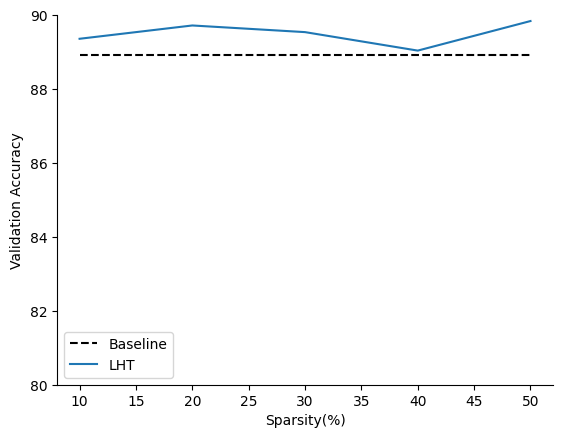

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(x=[10, 20, 30, 40, 50], y=[init_accuracy]*5, linestyle="--", label="Baseline", color="black")
sns.lineplot(x=[10, 20, 30, 40, 50], y=accuracies, label="LHT")
plt.ylim(80, 90)
plt.xlabel("Sparsity(%)")
plt.ylabel("Validation Accuracy")
sns.despine()